In [1]:
pip install --upgrade yfinance==0.2.54

In [2]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.4 MB/s eta 0:00:00


In [3]:
pip install scikit-learn

In [4]:
pip install pandas_datareader

In [18]:
pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.6 MB/s eta 0:00:00


In [1]:
import yfinance as yf
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm  # for CAPM and Fama-French regressions
import pandas_datareader
import matplotlib.pyplot as plt
from arch import arch_model
import itertools
from pypfopt import EfficientFrontier, risk_models, expected_returns, EfficientCVaR, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
import cvxpy as cp

In [2]:
def garch_aic_sel(returns):
    # Define grids for model parameters
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']

    results = []

    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0

                # -----------------------------
                # Fit the full model on the dataset
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')

                # -----------------------------
                # Get the AIC from the model
                aic = res.aic
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})

    # Find the best model based on AIC
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

In [4]:
#Combined Code

# ----------------------------
# 1. Load Fama–French Factor Data
# ----------------------------
ff = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# Date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
ff = ff.set_index('Date')
# Convert factor returns from percentages to decimals
ff = ff.astype(float) / 100

# ----------------------------
# 2. Forecast Factors using optimal GARCH(1,1) on 100x Scaled Data
# ----------------------------
forecast_results = {}
factors = ['Mkt-RF', 'SMB', 'HML']

for factor in factors:
    series_ = ff[factor].dropna()
    # convert to log-returns
    series = np.log(1 + series_)
    # Scale the series by 100 to stabilize the GARCH estimation
    mean, vol, dist = garch_aic_sel(100 * series)
    am = arch_model(100 * series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')

    # Forecast one period ahead (next month)
    forecast = res.forecast(horizon=1, reindex=False)

    # The forecasted mean is on a 100x scale and variance on a 100^2 scale.
    next_day_mean_ = forecast.mean.iloc[-1, 0]
    next_day_variance_ = forecast.variance.iloc[-1, 0]

    # convert back to simple returns
    next_day_mean = (np.exp(next_day_mean_ / 100) - 1)
    next_day_variance = (np.exp(next_day_variance_ / 100**2) - 1)

    forecast_results[factor] = {'next_day_mean': next_day_mean,
                                'next_day_variance': next_day_variance}
    print(f"Forecast for {factor} (next period): Mean = {next_day_mean}, Variance = {next_day_variance}")

# ----------------------------
# 3. Download Stock Data and Run Regressions
# ----------------------------
tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
prices = yf.download(tickers, start='2009-12-31', end='2024-12-31', interval='1mo', auto_adjust=True)['Close']

returns = prices.pct_change().dropna()

# Align dates of stock returns and factor data
common_dates = returns.index.intersection(ff.index)

# Check if common_dates is empty and handle accordingly
if len(common_dates) == 0:
    print("Error: No common dates found between stock returns and Fama-French data.")
    # Further investigation and data adjustment are needed
else:
    returns = returns.loc[common_dates]
    ff = ff.loc[common_dates]


# Run OLS regressions to estimate factor loadings and obtain residual variances.
results = {}   # to store regression outputs
coeffs = {}    # to store estimated coefficients for each ticker

for ticker in tickers:
    df = pd.DataFrame({'r': returns[ticker]})
    df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
    # Compute excess returns: r - RF
    df['excess'] = df['r'] - df['RF']

    # Independent variables are the three factors (with constant)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess']

    model = sm.OLS(y, X).fit()
    results[ticker] = model
    coeffs[ticker] = {
         'alpha': model.params['const'],
         'Mkt-RF': model.params['Mkt-RF'],
         'SMB': model.params['SMB'],
         'HML': model.params['HML']
    }

    print(f"\nRegression results for {ticker}:\n", model.summary())

# ----------------------------
# 4. Forecast Next Day Expected Returns (r_{i,t+1})
# ----------------------------
forecast_r = {}
for ticker in tickers:
    # r_{i,t+1} = alpha_i + beta_i,Mkt * (forecast_Mkt/100) + beta_i,SMB * (forecast_SMB/100) + beta_i,HML * (forecast_HML/100)
    alpha = coeffs[ticker]['alpha']
    r_forecast = alpha
    for factor in factors:
        beta = coeffs[ticker][factor]
        # Convert forecasted factor mean from 100x scale back to original scale by dividing by 100.
        factor_mean = forecast_results[factor]['next_day_mean'] / 100
        r_forecast += beta * factor_mean
    forecast_r[ticker] = r_forecast
    print(f"\nForecasted r_{ticker}, t+1: {r_forecast}")

# ----------------------------
# 5. Calculate Total Forecast Error Variance for r_{i,t+1}
# ----------------------------
# Total variance = sum_j (beta_{ij}^2 * (sigma_{j, forecast}^2 / 100^2)) + sigma^2_reg,
# where sigma^2_reg is the mean squared error (residual variance) from the regression.
forecast_error = {}
for ticker in tickers:
    beta_squared_sum = 0
    for factor in factors:
        beta = coeffs[ticker][factor]
        # Convert forecasted variance from 100x scale back to original scale: divide by 100^2.
        factor_variance = forecast_results[factor]['next_day_variance'] / (100**2)
        beta_squared_sum += (beta**2) * factor_variance

    sigma2_reg = results[ticker].mse_resid  # regression residual variance
    total_variance = beta_squared_sum + sigma2_reg
    forecast_error[ticker] = total_variance
    print(f"Total forecast error variance for {ticker}: {total_variance}")


Forecast for Mkt-RF (next period): Mean = 0.009348032713710985, Variance = 0.0016174797596937296
Forecast for SMB (next period): Mean = 0.000100729865492033, Variance = 0.0011715711160602549
Forecast for HML (next period): Mean = 0.0019801727210044806, Variance = 0.0008307418832074198


[*********************100%***********************]  8 of 8 completed



Regression results for AAPL:
                             OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     44.68
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.73e-21
Time:                        14:54:00   Log-Likelihood:                 256.44
No. Observations:                 179   AIC:                            -504.9
Df Residuals:                     175   BIC:                            -492.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095

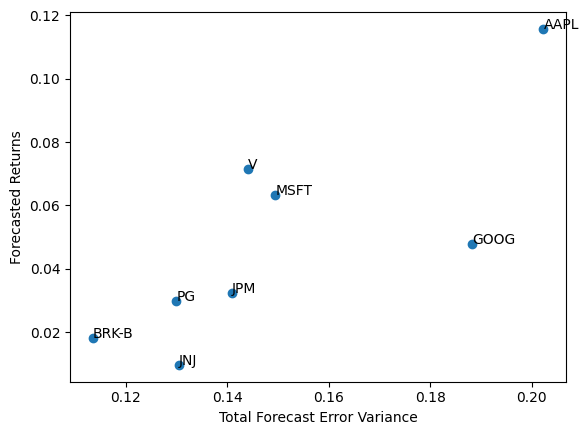

In [5]:
annualizer = 12

annualized_return = {ticker: forecast_r[ticker] * annualizer for ticker in tickers}
annualized_volatility = {ticker: np.sqrt(forecast_error[ticker]) * np.sqrt(annualizer) for ticker in tickers}

plt.scatter(annualized_volatility.values(), annualized_return.values())
# use ticker to label scatter plots
for ticker in tickers:
    plt.text(annualized_volatility[ticker], annualized_return[ticker], ticker)
plt.xlabel('Total Forecast Error Variance')
plt.ylabel('Forecasted Returns')
plt.show()

In [6]:
from pypfopt import EfficientFrontier, risk_models

# calculate the optimal max sharpe portfolio using the forecasted mean return as expected returns and the empirical covariance for risk
mu = pd.Series(annualized_return)
S = risk_models.sample_cov(prices, frequency=12)
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 8.1%
Annual volatility: 13.7%
Sharpe Ratio: 0.59


(np.float64(0.08105767587242596),
 np.float64(0.13696031119350693),
 np.float64(0.5918333213912029))

<Axes: >

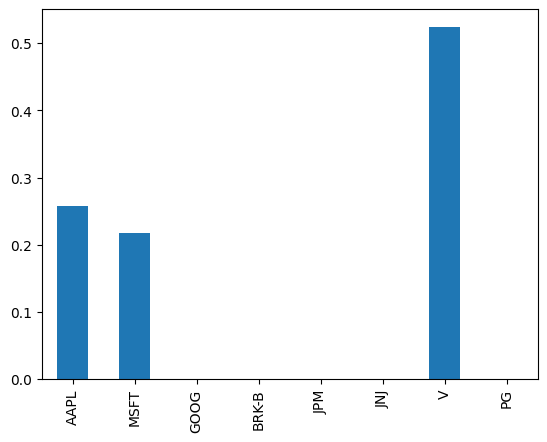

In [7]:
# plot the weights of the optimal portfolio
weights = pd.Series(weights)
weights.plot(kind='bar')


In [8]:
weights*100

AAPL     25.798296
MSFT     21.775190
GOOG      0.000000
BRK-B     0.000000
JPM       0.000000
JNJ       0.000000
V        52.426515
PG        0.000000
dtype: float64

In [ ]:
viewdict = {t:mu[t] for t in tickers}
viewdict

{'AAPL': np.float64(0.11575461895826425),
 'MSFT': np.float64(0.06317477812460809),
 'GOOG': np.float64(0.04768573840688553),
 'BRK-B': np.float64(0.018189694864199513),
 'JPM': np.float64(0.03232208074641386),
 'JNJ': np.float64(0.009617824989504904),
 'V': np.float64(0.0714114404483378),
 'PG': np.float64(0.029788077237626463)}

In [12]:
view_omega = np.diag([annualized_volatility[t] for t in tickers])
view_omega

array([[0.20234483, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.1494775 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.18831644, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.11349216, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.14087457,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.13045484, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.14402877, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.12997824]])

In [13]:
S_train = risk_models.sample_cov(prices)  # or however your train_data is defined

#print(S_train)

bl = BlackLittermanModel(S_train, absolute_views=viewdict, omega=view_omega)
mu_train = bl.bl_returns()
print(mu_train)

Ticker
AAPL     0.044424
BRK-B    0.016671
GOOG     0.030707
JNJ      0.012553
JPM      0.025428
MSFT     0.031705
PG       0.012615
V        0.028690
dtype: float64


/home/carlo/miniconda3/lib/python3.12/site-packages/pypfopt/black_litterman.py:258: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


Optimized Weights:
OrderedDict([('AAPL', 0.33664), ('BRK-B', 0.0), ('GOOG', 0.04002), ('JNJ', 0.0), ('JPM', 0.0), ('MSFT', 0.16622), ('PG', 0.14666), ('V', 0.31047)])


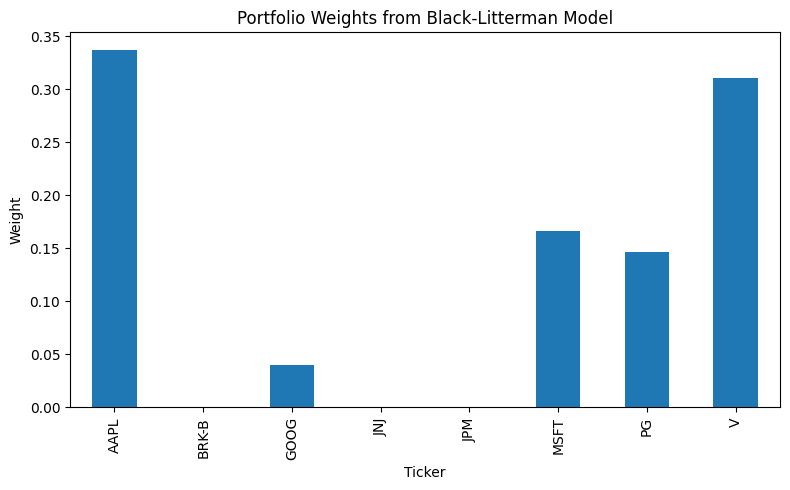

Expected annual return: 0.4%
Annual volatility: 75.8%
Sharpe Ratio: 0.01


In [62]:
ef_bl = EfficientFrontier(mu_train, S_train)
weights_bl = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print("Optimized Weights:")
print(cleaned_weights_bl)

# Plot the portfolio weights
weights_series = pd.Series(cleaned_weights_bl)
weights_series.plot(kind="bar", figsize=(8, 5))
plt.title("Portfolio Weights from Black-Litterman Model")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

# Optionally, display the portfolio performance metrics
performance = ef_bl.portfolio_performance(verbose=True)